# Optimal Contracts, Experiments

Javier, Saidur, Omid

Jan, 2023

University of Alberta, CS, SCRG

In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
from math import floor, log10, isclose
import matplotlib.pyplot as plt
from contracts import get_contract, l_transpose, get_contract_non_tract, get_contract_saidur, get_contract_customtypes
from sensitivity import sensitivity_experiment, expand_results, plot_sensitivity
from tabulate import tabulate
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Measuring error between different funcs

In [2]:
def get_contract2(num_types, n_ev, tau):   
    
    TAU = tau # contract duration
    ALPHA_D = 11
    DAY_HRS = 24

    GAMMA = 1
    KAPPA = 0.1
        
    M = num_types
    PI_M = np.ones(M) * (1/M)

    V_BATT = 150
    BAT_DEG = 2 * 80
    
    # VARS

    Y = cp.Variable(M, nonneg=True)
    Z = cp.Variable(M, nonneg=True)

    constraints = []
    
    for idx in range(M):
        theta_m = idx + 1
        
        if (idx == 0): # type-1
            constraints += [Y[idx] - ((Z[idx] * GAMMA)/(BAT_DEG * theta_m)) == 0]
            constraints += [Y[idx] >= 0]
            constraints += [Z[idx] >= 0]

        elif (idx >= 1):
            constraints += [(Y[idx] - ((Z[idx] * GAMMA)/(BAT_DEG * theta_m))) == (Y[idx-1] - ((Z[idx-1] * GAMMA)/(BAT_DEG * theta_m)))]
            constraints += [Y[idx] >= Y[idx-1]]
            constraints += [Z[idx] >= Z[idx-1]]
            constraints += [Z[idx] <= (ALPHA_D  * TAU)]          
            
    objective_func = np.zeros(M)

    for idx in range(M):
        objective_func += cp.sum((PI_M[idx]) * n_ev * (KAPPA*(cp.log(Z[idx]+1)) - (Y[idx])))

    obj = cp.Maximize(cp.sum(objective_func))
    prob = cp.Problem(obj, constraints)


    prob.solve(verbose=False)
    if prob.status != 'optimal':
        raise Exception("Optimal contracts not found")
    return Z.value, Y.value


In [3]:
get_contract2(3, 10, 1)

(array([ 6.99922536, 10.99999897, 10.99999975]),
 array([0.04374516, 0.05624758, 0.05624758]))

In [4]:
get_contract_customtypes([1,2,3], n_ev = 10, GAMMA = 1, KAPPA = 0.1, TAU = 1)

(array([0.04373253, 0.05624125, 0.05624125]),
 array([ 6.99720489, 10.99999468, 10.99999657]))

In [5]:
get_contract_non_tract(3)

(array([0.02188081, 0.04687038, 0.05729206]),
 array([ 7.0018588 , 22.9951837 , 32.99999582]))

In [6]:
get_contract_saidur(3, BAT_DEG = 160)

(array([0.02189106, 0.04691175, 0.05730916]),
 array([ 7.00514039, 23.01837902, 32.99989416]))

In [7]:
M = list(range(1,10))
l_ng = []
l_nw = []
for i in M:
    gt, wt = get_contract(i)
    gn, wn = get_contract_non_tract(i)
    n_g = np.linalg.norm(gt-gn)
    n_w = np.linalg.norm(wt-wn)
    l_ng.append(n_g)
    l_nw.append(n_w)

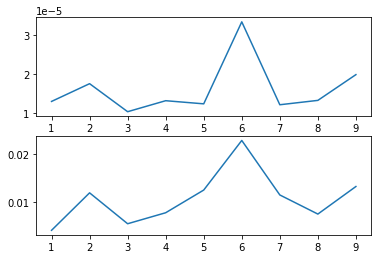

In [8]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)

ax1.plot(M, l_ng)
ax2.plot(M, l_nw)

## Finding what values give unique contracts

In [9]:
def unique_contracts(gs, ws):
    sig = 3
    g_round = [round(g, sig-int(floor(log10(abs(g))))-1) for g in gs]
    w_round = [round(w, sig-int(floor(log10(abs(w))))-1) for w in ws]
    
    g_nunique = len(np.unique(g_round))
    w_nunique = len(np.unique(w_round))
    
    #print(g_round)
    #print(w_round)
    assert g_nunique == w_nunique
    return g_nunique

def list_stringy(my_list, max_line):
    res_str = "["
    line_count = 1
    for elem in my_list:
        res_str += str(round(elem,2)) + ", "
        if len(res_str) > max_line*line_count:
            res_str = res_str[:-1]
            res_str += '\n'
            line_count += 1
    res_str = res_str[:-2]
    res_str += "]"
    
    if len(res_str) > max_line*5:
        for i in range(len(res_str)):
            if res_str[i] == '\n':
                break
        temp_res = res_str[:i]
        temp_res += "\n...\n"
        for i in range(len(res_str)):
            if res_str[-i] == '\n':
                break
        temp_res += res_str[-(i-1):]
        res_str = temp_res
    return res_str

In [10]:
contracts = get_contract_customtypes([1,2,3])
unique_contracts(contracts[0], contracts[1])

3

In [11]:
contracts = get_contract_customtypes([1,2,3,4])
print(contracts)
unique_contracts(contracts[0], contracts[1])

(array([0.01690456, 0.03689417, 0.05230722, 0.05230764]), array([ 5.4094577 , 18.20281029, 32.99934366, 32.99987707]))


3

In [12]:
meta_thetas = [[1,2,3],
               [1,2,3,4],
               [1,2,4,16],
               [1,2,4,32],
               list(np.linspace(0.5,2,   10)),
               list(np.linspace(0.5,2,   100)),
               list(np.linspace(0.5,3,   10)),
               list(np.linspace(0.5,2.9, 7)),
               list(np.linspace(0.1, 10,  10)),
               sorted(list(np.divide(1,np.linspace(0.25,4,10)))),
               sorted(list(np.divide(1,np.linspace(0.2, 5,10)))),
               sorted(list(np.divide(1,np.linspace(0.1, 10,10)))),
               sorted(list(np.divide(1,np.linspace(0.1, 10,50)))),
              ]

res_table = []
for thetas in meta_thetas:
    ntypes = len(thetas)
    gs, ws = get_contract_customtypes(thetas)
    ncontracts = unique_contracts(gs, ws)
    res = "Unique" if ntypes == ncontracts else "Repeated"
    str_thetas = list_stringy(thetas, 40)
    res_table.append([str_thetas, ntypes, ncontracts, res])
    
print(tabulate(res_table, headers = ["thetas", "# types", "# unique contracts", "result"], tablefmt="grid"))

+-----------------------------------------------+-----------+----------------------+----------+
| thetas                                        |   # types |   # unique contracts | result   |
+===============================================+===========+======================+==========+
| [1, 2, 3]                                     |         3 |                    3 | Unique   |
+-----------------------------------------------+-----------+----------------------+----------+
| [1, 2, 3, 4]                                  |         4 |                    3 | Repeated |
+-----------------------------------------------+-----------+----------------------+----------+
| [1, 2, 4, 16]                                 |         4 |                    3 | Repeated |
+-----------------------------------------------+-----------+----------------------+----------+
| [1, 2, 4, 32]                                 |         4 |                    3 | Repeated |
+---------------------------------------

## Getting percentiles of prices

In [13]:
df_price = pd.read_csv('../sampling_price_data.csv')
#display(df_price[["price_imbalance", "Hour"]].describe())
gdf_price = df_price.groupby("Hour").agg(price_imbalance = ("price_imbalance", "mean")).reset_index()
#gdf_price.head(50)
pr_10 = np.percentile(df_price["price_imbalance"], 10)
pr_25 = np.percentile(df_price["price_imbalance"], 25)
pr_50 = np.percentile(df_price["price_imbalance"], 50)
pr_75 = np.percentile(df_price["price_imbalance"], 75)
pr_90 = np.percentile(df_price["price_imbalance"], 90)

print(f"{pr_10=:.2f}, {pr_25=:.2f}, {pr_50=:.2f}, {pr_75=:.2f}, {pr_90=:.2f}, ")
df_price.describe()

pr_10=0.01, pr_25=0.02, pr_50=0.04, pr_75=0.06, pr_90=0.10, 


,price_da,price_imbalance,Hour
count,32880.000000,32880.000000,32880.000000
mean,0.047930,0.047552,11.500000
std,0.024525,0.053456,6.922292
min,-0.079190,-0.414170,0.000000
25%,0.033867,0.023190,5.750000
50%,0.043890,0.037283,11.500000
75%,0.056570,0.059684,17.250000
max,0.248280,0.717250,23.000000


## Plotting unique contracts

In [14]:
def plot_contracts(ax1, ax2, gamma, kappa, thetas, color, tau=3, alpha_d = 11, marker=".",  text1=False, text2 = False, label = None):
    gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d, n_ev = 1)
    
    unique = unique_contracts(gs, ws)
    fontsize_title = 34
    fontsize = 26
    fontsize_txt = 21
    markersize = 140
    
    ax1.scatter(ws, gs, color = color, marker=marker, s = markersize, label=label, alpha = 0.8)
    
    gs_1, ws_1, txt_off = -1, -1, 0
    if text1:
        for i, theta in enumerate(thetas):
            if round(ws[i], 3) ==  round(ws_1, 3) and round(gs[i], 3) == round(gs[i], 3):
                txt_off += 5 + txt_off * 0.04
                ax1.text(x = ws[i] + txt_off, y = gs[i], s = r"  , $\theta = $ " + f"{theta:.2f}   ", va = "center", ha = "left", fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 1.25 and tau == 2:
                ax1.text(x = ws[i], y = gs[i] - 0.01, s = r"   $\theta = $ " + f"{theta:.2f}   ", va = "center", ha = "left", fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 1.5 and tau == 2:
                ax1.text(x = ws[i], y = gs[i] + 0.01, s = r"   $\theta = $ " + f"{theta:.2f}   ", va = "center", ha = "left", fontsize = fontsize_txt)
            else:
                ax1.text(x = ws[i], y = gs[i], s = r"   $\theta = $ " + f"{theta:.2f}   ", va = "center", ha = "left", fontsize = fontsize_txt)
            gs_1, ws_1 = gs[i], ws[i]
            
            
            
    rate = np.divide(np.array(gs), np.array(ws))
    ax2.scatter(ws, rate, color = color, marker = marker, s = markersize, label = label, alpha = 0.8)
    
    if gamma == 0.01:
        va2 = "bottom"
        ha2 = "center"
        voff2 = 0.0015
    else:
        va2 = "center"
        ha2 = "left"
        voff2 = 0
        
    gs_1, ws_1, txt_off = -1, -1, 0
    if text2:
        for i, theta in enumerate(thetas):
            if round(ws[i], 3) == round(ws_1, 3) and round(gs[i], 3) == round(gs_1, 3):
                txt_off += 5 + txt_off * 0.04
                ax2.text(x = ws[i] + txt_off, y = rate[i] + voff2, s = r"  , $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 1.25 and tau == 2:
                ax2.text(x = ws[i] + txt_off - 1.5, y = rate[i] + voff2 + 0.002, s = r"  $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 1.50 and tau == 2:
                ax2.text(x = ws[i] + txt_off + 2, y = rate[i] + voff2, s = r"  $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 0.50:
                ax2.text(x = ws[i] + txt_off, y = rate[i] + voff2 + 0.002, s = r"  $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            elif gamma == 0.01 and theta == 1.00 and tau == 1:
                txt_off += 1.7
                ax2.text(x = ws[i] + txt_off, y = rate[i] + voff2, s = r"   $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            else:
                ax2.text(x = ws[i], y = rate[i] + voff2, s = r"   $\theta = $ " + f"{theta:.2f}   ", va = va2, ha = ha2, fontsize = fontsize_txt)
            gs_1, ws_1 = gs[i], ws[i]
    

        
    xticks = np.arange(0, 35.1, 5)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f"{x:.0f}" for x in xticks], fontsize = fontsize_txt)
    
    yticks1 = np.arange(0, 0.36, 0.05)
    ax1.set_yticks(yticks1)
    ax1.set_yticklabels([f"{y:.2f}" for y in yticks1], fontsize = fontsize_txt)
    
    
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f"{x:.0f}" for x in xticks], fontsize = fontsize_txt)
    
    yticks2 = np.arange(0, 0.136, 0.02)
    ax2.set_yticks(yticks2)
    ax2.set_yticklabels([f"{y:.2f}" for y in yticks2], fontsize = fontsize_txt)
    
    ax1.set_xlim(-0.4, 38)
    ax2.set_xlim(-0.4, 38)

    if kappa == 0.2:
        ax1.set_ylim(-0.008, 0.40)
    elif kappa == 0.3:
        ax1.set_ylim(-0.008, 0.45)
    ax2.set_ylim(-0.004, 0.14)

    ymin1, ymax1 = ax1.get_ylim()
    ymin2, ymax2 = ax2.get_ylim()
    a = 0.25
    ax1.vlines(11*tau, ymin1, 0.31, color = "gray", alpha = 0.4, ls="--")
    ax2.vlines(11*tau, ymin2, 0.11, color = "gray", alpha = 0.4, ls="--")

    ha = "left" if tau == 1 else "right"
    #ax1.text(alpha_d * tau, (1-a)*ymin1 + a*ymax1, s = r" $\alpha_d \times l_{V2G} = $" + f"{alpha_d * tau}  ", fontweight="bold", fontsize = fontsize, ha=ha )
    #ax2.text(alpha_d * tau, (1-a)*ymin2 + a*ymax2, s = r" $\alpha_d \times l_{V2G} = $" + f"{alpha_d * tau}  ", fontweight="bold", fontsize = fontsize, ha=ha )

    
    ax2.hlines(gamma, 0, 38, color = 'gray', alpha = 0.8, ls = ":")
    

    xtext_pr = 9.5
    if gamma == 0.01:
        voff = -0.002
        va = "top"
        s2 = f"Future scenario:   Actual batt. deg. = {gamma:.2f} (€/kWh)"
    else:
        voff = 0.002
        va = "bottom"
        s2 = f"Current scenario: Actual batt. deg. = {gamma:.2f} (€/kWh)"
    ax2.text(xtext_pr, gamma + voff, s2, color = "gray", va = va, fontsize = fontsize_txt+1)
    


    ax1.legend(loc = "upper center", frameon = True, fontsize = fontsize-4)
    ax2.legend(loc = "upper center", frameon = True, fontsize = fontsize-4)
        
    ax1.set_xlabel(f"(a{4-tau})", family = "serif", fontweight = "bold", fontsize = fontsize + 4)
    ax2.set_title(f"(b{4-tau})", family = "serif", fontweight = "bold", fontsize = fontsize + 4, y = -0.22)
    #ax1.set_xlabel("w, energy (in kWh)", fontsize =14)
    ax2.set_xlabel(r"w, energy (kWh)", fontsize = fontsize+4)
    if tau == 3:
        ax1.set_ylabel("g, payoff (€)", fontsize =fontsize+4)
        ax2.set_ylabel(r"g/w, payoff per energy (€ / kWh)", fontsize =fontsize+4)
    
    ax1.set_title(r"Contracts with $\ell_{V2G}$ =" + f"{tau}", fontsize = fontsize_title)
    return ax1, ax2, gs, ws

In [15]:
def myboxplot(ax1, ax2, df_price):
    fontsize = 28
    fontsize_txt = 21
    
    ax1.set_axis_off()
    plies = [10, 25, 50, 75, 90]
    plies_val = [np.percentile(df_price["price_imbalance"], p) for p in plies]
    
    ax2.boxplot(df_price["price_imbalance"], showfliers=False, whis = [10, 90], medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick'))
    
    yticks2 = np.arange(0, 0.136, 0.02)
    ax2.set_yticks(yticks2)
    ax2.set_yticklabels([f"{y:.2f}" for y in yticks2], fontsize = fontsize_txt)
    ax2.set_ylim(-0.004, 0.14)
    
    for p, p_val in zip(plies, plies_val):
        if p in [10, 90]:
            xtext = 1.4
        else:
            xtext = 1.45
        ax2.text(xtext, p_val, f"← p{p}", ha = "center", va = "center", fontsize = fontsize_txt, color = "gray")
    
    ax2.set_xlim(0.6, 1.8)
    ax2.set_xticks([1])
    ax2.set_xticklabels([" "])
    ax2.set_xlabel(r"Imbalance price", fontsize = fontsize)
    ax2.set_title(f"(b4)", family = "serif", fontweight = "bold", fontsize = fontsize + 4, y = -0.22)
    return ax1, ax2

(2, 4)
tau=3, min(ws2)=3.2896567153180074
[0.06579313 0.12295683 0.18008745 0.23715386 0.29443842] [ 3.28965672  7.57693394 13.28999575 20.42329686 29.01598153]
tau=2, min(ws4)=3.287563989430555
[0.06575128 0.12291645 0.17998333 0.23703614 0.24761297] [ 3.28756399  7.57495165 13.28163988 20.41324155 21.99976611]
tau=1, min(ws6)=3.286743492186058
[0.06573487 0.1228486  0.15714585 0.15714586 0.15714586] [ 3.28674349  7.57027361 10.99999814 10.99999953 10.99999981]


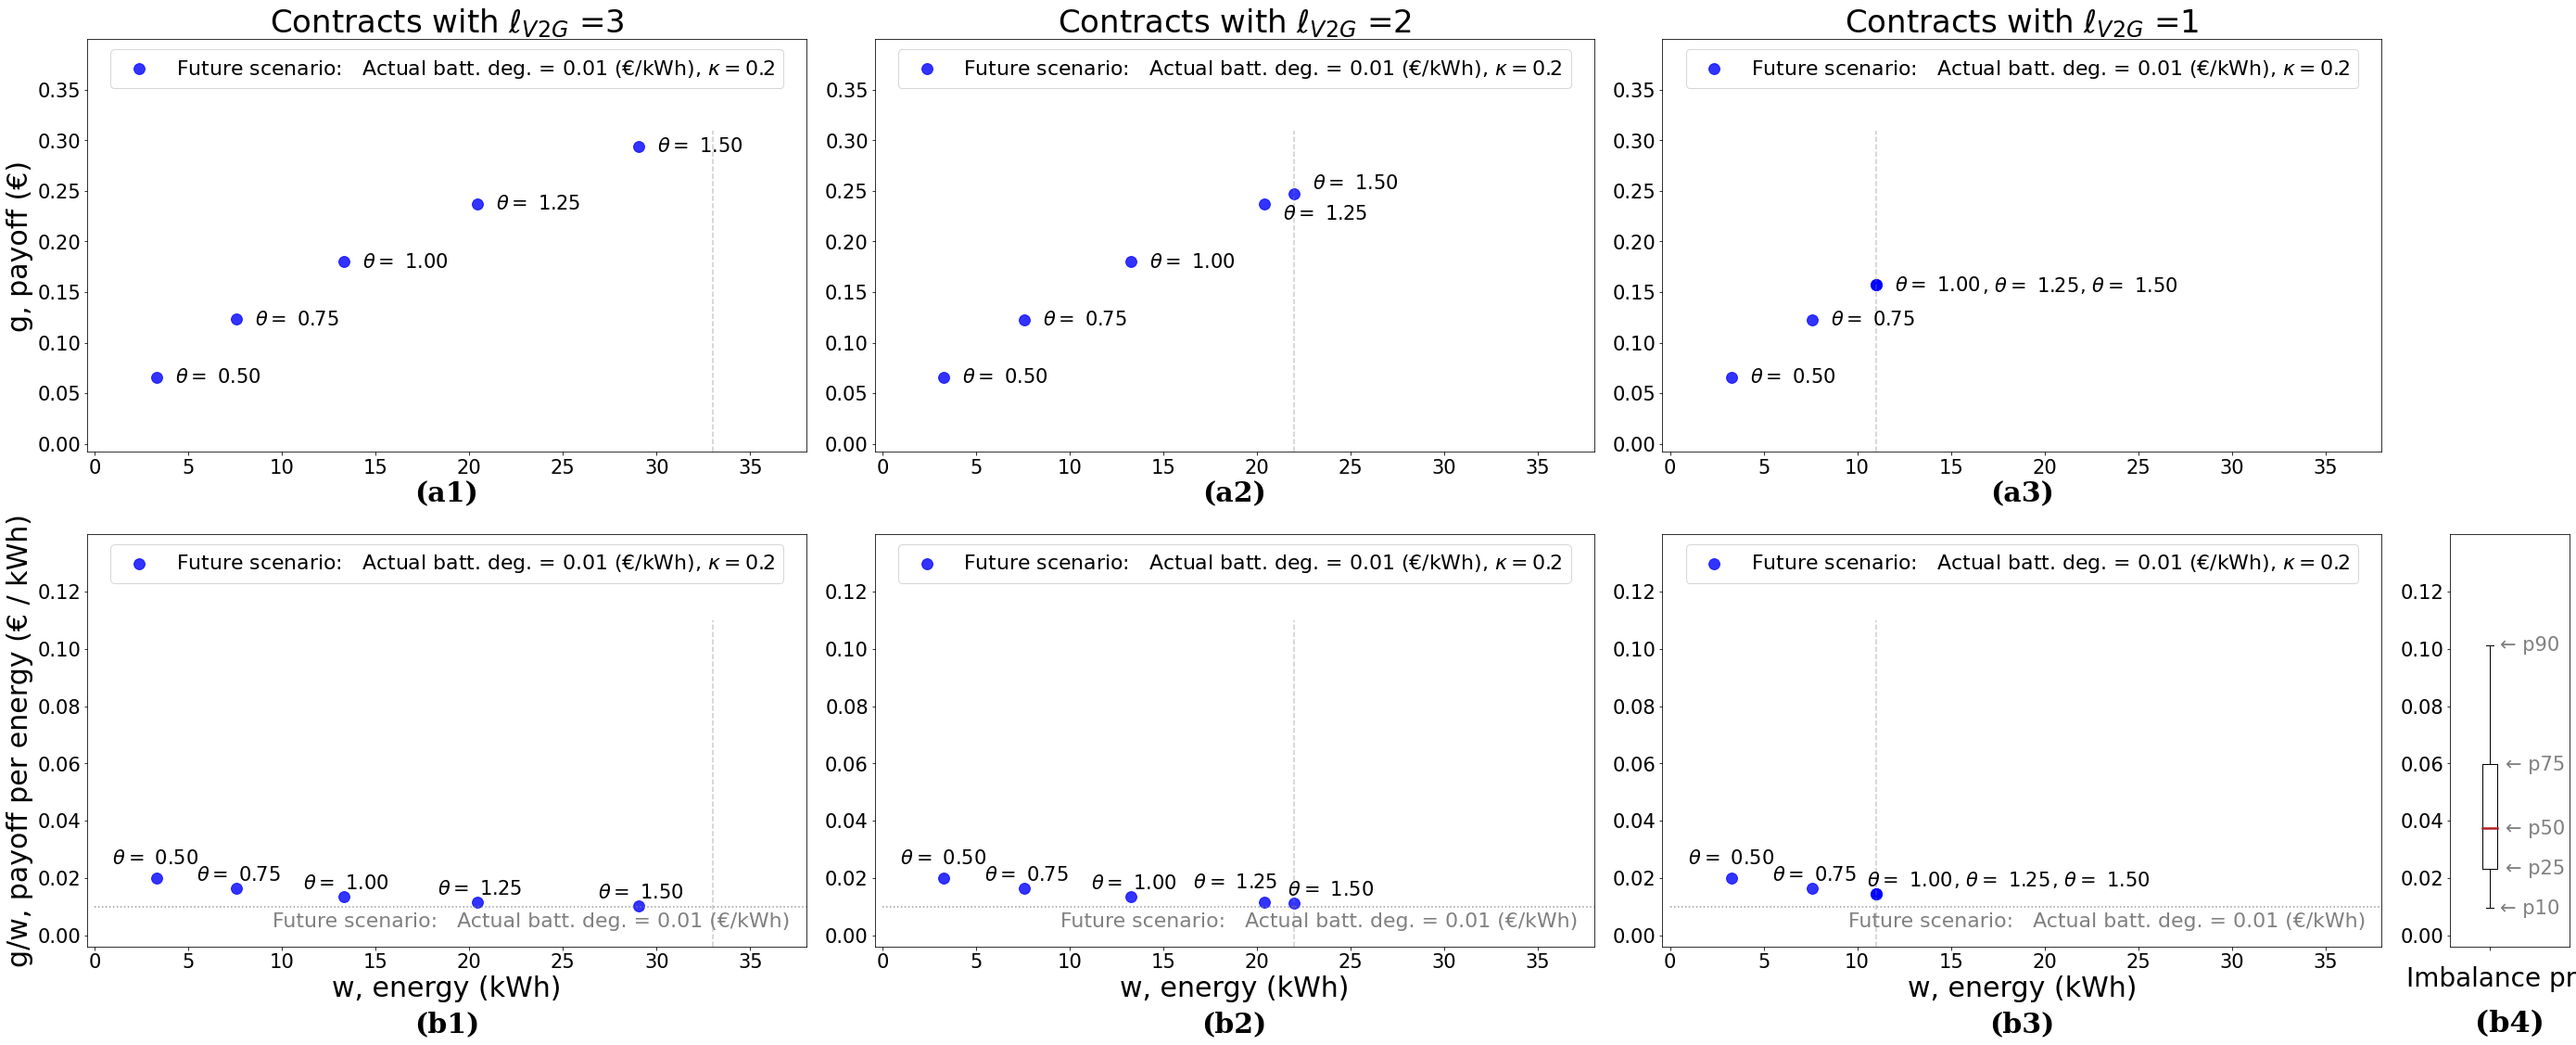

In [16]:
#thetas = np.logspace(log10(0.25), log10(2), num=10, endpoint=True, base=10)
thetas = [0.5, 0.75, 1, 1.25, 1.5]
kappa  = 0.2
gamma1 = 0.05
gamma2 = 0.01

alpha_d = 11
fig1, axs = plt.subplots(2, 4, figsize = (48,18), gridspec_kw={'width_ratios': [6, 6, 6, 1], 'wspace': 0.12})
print(axs.shape)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs[0,0], axs[1,0], axs[0,1], axs[1,1], axs[0,2], axs[1,2], axs[0,3], axs[1,3]
#fig1 = plt.figure(figsize = (24,9))
#ax1 = fig1.add_subplot(2,4,1)
#ax2 = fig1.add_subplot(2,4,5)
#ax3 = fig1.add_subplot(2,4,2)
#ax4 = fig1.add_subplot(2,4,6)
#ax5 = fig1.add_subplot(2,4,3)
#ax6 = fig1.add_subplot(2,4,7)
#ax7 = fig1.add_subplot(2,4,4)
#ax8 = fig1.add_subplot(2,4,8)

tau = 3
ax1, ax2, gs1, ws1 = plot_contracts(ax1, ax2, gamma1, kappa, thetas, "red",  alpha_d = alpha_d, tau = tau, marker = '^', label = f"Current scenario: Actual batt. deg. = {gamma1:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
ax1, ax2, gs2, ws2 = plot_contracts(ax1, ax2, gamma2, kappa, thetas, "blue", alpha_d = alpha_d, tau = tau, marker = 'o', label = f"Future scenario:   Actual batt. deg. = {gamma2:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
print(f"{tau=}, {min(ws2)=}")
print(gs2, ws2)
tau = 2
ax3, ax4, gs3, ws3 = plot_contracts(ax3, ax4, gamma1, kappa, thetas, "red",  alpha_d = alpha_d, tau = tau, marker = '^', label = f"Current scenario: Actual batt. deg. = {gamma1:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
ax3, ax4, gs4, ws4 = plot_contracts(ax3, ax4, gamma2, kappa, thetas, "blue", alpha_d = alpha_d, tau = tau, marker = 'o', label = f"Future scenario:   Actual batt. deg. = {gamma2:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
us = gs2 - np.divide(ws2*gamma2, thetas)
print(f"{tau=}, {min(ws4)=}")
print(gs4, ws4)
tau = 1
ax5, ax6, gs5, ws5 = plot_contracts(ax5, ax6, gamma1, kappa, thetas, "red",  alpha_d = alpha_d, tau = tau, marker = '^', label = f"Current scenario: Actual batt. deg. = {gamma1:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
ax5, ax6, gs6, ws6 = plot_contracts(ax5, ax6, gamma2, kappa, thetas, "blue", alpha_d = alpha_d, tau = tau, marker = 'o', label = f"Future scenario:   Actual batt. deg. = {gamma2:.2f} (€/kWh), $\kappa = {kappa}$", text1 = True, text2 = True)
print(f"{tau=}, {min(ws6)=}")
print(gs6, ws6)
ax7, ax8 = myboxplot(ax7, ax8, df_price)

#fig1.tight_layout()



contract_table = [["1"] + [f"({g:.2f}, {w:.1f})" for g,w in zip(gs2,ws2)],
                  ["2"] + [f"({g:.2f}, {w:.1f})" for g,w in zip(gs4,ws4)],
                  ["3"] + [f"({g:.2f}, {w:.1f})" for g,w in zip(gs6,ws6)],
                 ]

headers = ["l_v2g"] + [str(theta) for theta in thetas]

df_contracts = pd.DataFrame(contract_table, columns = headers)
df_contracts.head()
#print(tabulate(contract_table, headers = headers))

fig1.savefig("/home/javier/Documents/Escuela/SCRG/Refs/Contracts/Figs/fig_optimalContracts.pdf", dpi = 600, bbox_inches='tight')

In [17]:
np.mean(np.log10(ws6 + 1) - gs6)

0.828528956501726

In [18]:
np.divide(1, [6/3, 5/3, 4/3, 3/3, 2/3, 1/3])

array([0.5 , 0.6 , 0.75, 1.  , 1.5 , 3.  ])

[0.5        0.58326452 0.680395   0.79370053 0.92587471 1.08005974
 1.25992105 1.46973449 1.71448797 2.        ]
[0.06756876 0.0859116  0.10591007 0.12782131 0.15221959 0.16326428
 0.16326448 0.16326453 0.16326455 0.16326455]
[ 3.37843813  4.448311    5.8089963   7.54809322  9.80706809 10.99996081
 10.99998571 10.99999224 10.99999556 10.99999723]
[0.00000000e+00 1.17472004e-09 1.09110290e-03 4.88017268e-03
 1.12651358e-02 2.02152956e-02 3.17791910e-02 4.61027231e-02
 6.34557660e-02 8.42788743e-02]


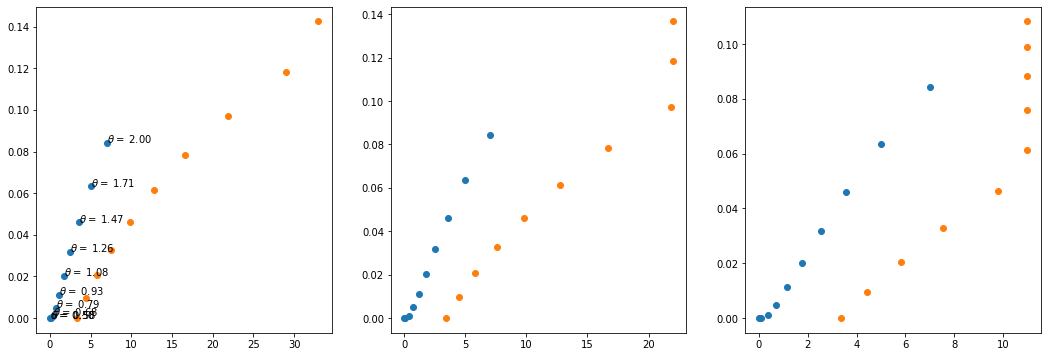

In [19]:
# Plot utility
thetas = np.logspace(log10(0.5), log10(2), num=10, endpoint=True, base=10)

kappa  = 0.2
gamma1 = 0.05
gamma2 = 0.01

alpha_d = 11


fig1 = plt.figure(figsize = (18,6))
ax1 = fig1.add_subplot(1,3,1)
ax2 = fig1.add_subplot(1,3,2)
ax3 = fig1.add_subplot(1,3,3)

tau = 3
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma1, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
us = gs -  np.divide(ws * gamma1, thetas)
ax1.scatter(ws, us)
for theta, w, u in zip(thetas, ws, us):
    ax1.text(w,u, r'$\theta =$' + f" {theta:.2f}")
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma2, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
us = gs -  np.divide(ws * gamma2, thetas)
ax1.scatter(ws, us)

tau = 2
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma1, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
us = gs -  np.divide(ws * gamma1, thetas)
ax2.scatter(ws, us)
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma2, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
us = gs -  np.divide(ws * gamma2, thetas)
ax2.scatter(ws, us)

tau = 1
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma1, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
us = gs -  np.divide(ws * gamma1, thetas)
ax3.scatter(ws, us)
gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma2, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
print(thetas)
print(gs)
print(ws)
print(us)

us = gs -  np.divide(ws * gamma2, thetas)
ax3.scatter(ws, us)


TypeError: plot_contracts() got an unexpected keyword argument 'set_annot'

/home/javier/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


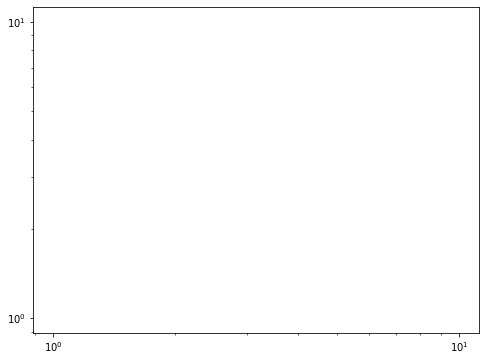

In [39]:
thetas = np.logspace(log10(0.5), log10(2), num=30, endpoint=True, base=10)

tau = 3
alpha_d = 20000

kappas = [0.1, 0.3, 1, 3]
#gammas = np.logspace(log10(0.001), log10(0.05), num = 5) #[0.001, 0.003, 0.01, 0.03, 0.1]

gammas = np.logspace(log10(0.01), log10(0.3), num = 5)
colors = ["orange", "purple", "red", "green", "blue", "black"]


fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1, yscale = "log", xscale = "log")

for kappa, color in zip(kappas, colors):
    ax1.scatter(-100, -100, color = color, label = f"$\kappa$ = {kappa}", alpha = 1)
    for gamma in gammas:
        ax1, _, _, _, =  plot_contracts(ax1, ax2, gamma, kappa, thetas, color,
                                        alpha_d = alpha_d,
                                        tau = tau, set_annot = False)




ax1.set_xlabel("w, Energy (in kWh)", fontsize = 14)
ax1.set_ylabel("g, Payoff (in USD)", fontsize = 14)

axmin, axmax = ax1.get_ylim()
ax1.vlines(3 * 11, axmin, axmax, color = "gray", ls = "--" )
ax1.vlines(8 * 11, axmin, axmax, color = "gray", ls = "--" )
#ax1.legend(loc = "upper left")


#ax1.set_xlim(10**(-2), 10**(3))
#ax1.set_ylim(10**(-2), 10**(2))

#ax1.set_xlim(-2, 700)
#ax1.set_ylim(-.2, 8)
ax1.legend(loc = "lower right")

## Trying different Kappa values

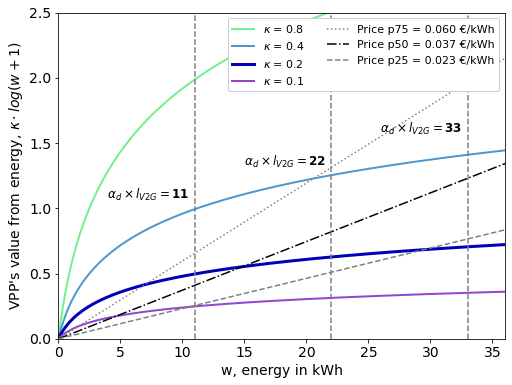

In [20]:
thetas = np.logspace(log10(0.5), log10(2), num=10, endpoint=True, base=10)



gamma1 = 0.05
gamma2 = 0.01

#kappas = [0.03, 0.1, 0.2, 0.3, 1, 3 ]
#kappas = [0.1, 0.2, 0.3, 0.5]
kappas = [0.1, 0.2, 0.4, 0.8][::-1]
colors = ["#9544cf", "#0000BB",  "#4d98d1", "#73f08e",][::-1]

fontsize = 14
alpha_d = 11
tau = 3

fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)

w_hat = np.linspace(0, 38, num = 200)
for kappa, color in zip(kappas, colors): #np.sort(kappas)[::-1]: sort descending
    VPP = kappa* np.log(w_hat + 1)
    if kappa == 0.2:
        lw = 3
    else:
        lw = 2
    ax1.plot(w_hat, VPP, label = f"$\kappa$ = {kappa}", color = color, lw = lw)

#ax1.plot(-1, -1, color="white", label = " ")
ax1.plot(w_hat, pr_75*w_hat, color = 'gray', ls = ':', label = f'Price p75 = {pr_75:.3f} €/kWh')
ax1.plot(w_hat, pr_50*w_hat, color = 'black', ls = '-.', label = f'Price p50 = {pr_50:.3f} €/kWh')
ax1.plot(w_hat, pr_25*w_hat, color = 'gray', ls = '--',  label = f'Price p25 = {pr_25:.3f} €/kWh')

ax1.set_ylabel(r"VPP's value from energy, $\kappa \cdot log(w + 1)$", fontsize = 14)
ax1.set_xlabel("w, energy in kWh", fontsize = 14)

ax1.set_xlim([0, 36])
ax1.set_ylim([0, 2.5])

x_ticks = np.arange(0, 35.1, step = 5)
y_ticks = np.arange(0, 2.51, step = 0.5)

ax1.set_xticks(x_ticks)
ax1.set_xticklabels([f"{x:.0f}" for x in x_ticks], fontsize = fontsize)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f"{y:.1f}" for y in y_ticks], fontsize = fontsize)

ymin1, ymax1 = ax1.get_ylim()

for tau in [1,2,3]:
    a = 0.1 * tau + 0.33
    ax1.vlines(11*tau, ymin1, ymax1, color = "gray", ls="--")
    ha = "left" if tau == 1 else "right"
    ha = "right"
    ax1.text(alpha_d * tau, (1-a)*ymin1+ a*ymax1, s = r" $\alpha_d \times l_{V2G} = $" + f"{alpha_d * tau}  ", fontweight="bold", fontsize = 12, ha=ha )

ax1.legend(loc = "upper right", ncol=2, framealpha = 1, fontsize = fontsize-3)
fig1.savefig("/home/javier/Documents/Escuela/SCRG/Refs/Contracts/Figs/fig_vppKappa.pdf", dpi = 600)

## Profit

In [21]:
kappas  = [0.2, 0.3]
gamma = 0.01
thetas = np.logspace(log10(0.5), log10(1), num=10, endpoint=True, base=10)
taus = [1,2,3]
alpha_d = 11

pi = 1 / len(thetas)

for kappa in kappas:
    for tau in taus:
        gs, ws = get_contract_customtypes(thetas, KAPPA=kappa, GAMMA=gamma, BAT_DEG = 1, TAU = tau, ALPHA_D = alpha_d)
        revenue = 0
        for g, w in zip(gs,ws):
            revenue += pi *(kappa * log10(w + 1) - g)
        print(f"{kappa=}, {tau=}, {revenue=:.4f}")

kappa=0.2, tau=1, revenue=0.0356
kappa=0.2, tau=2, revenue=0.0262
kappa=0.2, tau=3, revenue=0.0262
kappa=0.3, tau=1, revenue=0.1140
kappa=0.3, tau=2, revenue=0.0875
kappa=0.3, tau=3, revenue=0.0821


### A random choice object in numpy can change states inside the function

In [22]:
def random_choice(rng):
    print(rng.choice([1,2,3]))

In [23]:
rng = np.random.default_rng(1)
print(rng.choice([1,2,3]))
print(rng.choice([1,2,3]))
print(rng.choice([1,2,3]))

2
2
3


In [24]:
rng = np.random.default_rng(1)
random_choice(rng)
random_choice(rng)
print(rng.choice([1,2,3]))

2
2
3
